In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# Create customer segments with different characteristics
n_customers = 2000  # 1000 retail, 1000 distributor
segments = ['Retail'] * 1000 + ['Distributor'] * 1000

# Base parameters for each segment
base_params = {
    'Retail': {'base_price': 100, 'price_elasticity': -1.8, 'base_demand': 50},
    'Distributor': {'base_price': 85, 'price_elasticity': -1.2, 'base_demand': 200}
}

# Generate customer data
data = []
for i, segment in enumerate(segments):
    params = base_params[segment]
    customer_id = f"{segment[0]}_{i:04d}"

    # Pre-experiment period (4 weeks)
    for week in range(1, 5):
        price = params['base_price']
        # Simulate demand with some randomness
        demand = max(5, int(params['base_demand'] * np.random.uniform(0.8, 1.2)))
        cost = price * 0.6  # Assume 40% margin
        revenue = price * demand
        gross_margin = revenue - (cost * demand)

        data.append({
            'customer_id': customer_id,
            'segment': segment,
            'week': week,
            'period': 'pre',
            'price': price,
            'demand': demand,
            'revenue': revenue,
            'gross_margin': gross_margin
        })

    # Experiment period (4 weeks)
    # Randomly assign to control or treatment group
    group = 'Treatment' if np.random.random() > 0.5 else 'Control'

    for week in range(5, 9):
        # Control group keeps original price
        if group == 'Control':
            price = params['base_price']
        # Treatment group gets 5% price increase
        else:
            price = params['base_price'] * 1.05

        # Calculate demand based on price elasticity
        price_change = (price - params['base_price']) / params['base_price']
        demand_change = params['price_elasticity'] * price_change
        base_demand = params['base_demand'] * np.random.uniform(0.8, 1.2)
        demand = max(5, int(base_demand * (1 + demand_change)))

        cost = price * 0.6  # Assume 40% margin
        revenue = price * demand
        gross_margin = revenue - (cost * demand)

        data.append({
            'customer_id': customer_id,
            'segment': segment,
            'week': week,
            'period': 'post',
            'group': group,
            'price': price,
            'demand': demand,
            'revenue': revenue,
            'gross_margin': gross_margin
        })

# Create DataFrame
df = pd.DataFrame(data)
print("📊 First 5 rows of data:")
print(df.head())
print(f"\n📈 Total records: {len(df)}")
print(f"👥 Group distribution:")
print(df[df['period'] == 'post']['group'].value_counts())

📊 First 5 rows of data:
  customer_id segment  week period  price  demand  revenue  gross_margin  \
0      R_0000  Retail     1    pre  100.0      47   4700.0        1880.0   
1      R_0000  Retail     2    pre  100.0      59   5900.0        2360.0   
2      R_0000  Retail     3    pre  100.0      54   5400.0        2160.0   
3      R_0000  Retail     4    pre  100.0      51   5100.0        2040.0   
4      R_0000  Retail     5   post  100.0      43   4300.0        1720.0   

     group  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4  Control  

📈 Total records: 16000
👥 Group distribution:
group
Treatment    4008
Control      3992
Name: count, dtype: int64


📋 Summary Statistics:
                               price  demand   revenue  gross_margin
segment     period group                                            
Distributor post   Control     85.00  199.26  16937.13       6774.85
                   Treatment   89.25  187.22  16709.55       6683.82
Retail      post   Control    100.00   49.41   4940.76       1976.30
                   Treatment  105.00   44.78   4701.40       1880.56


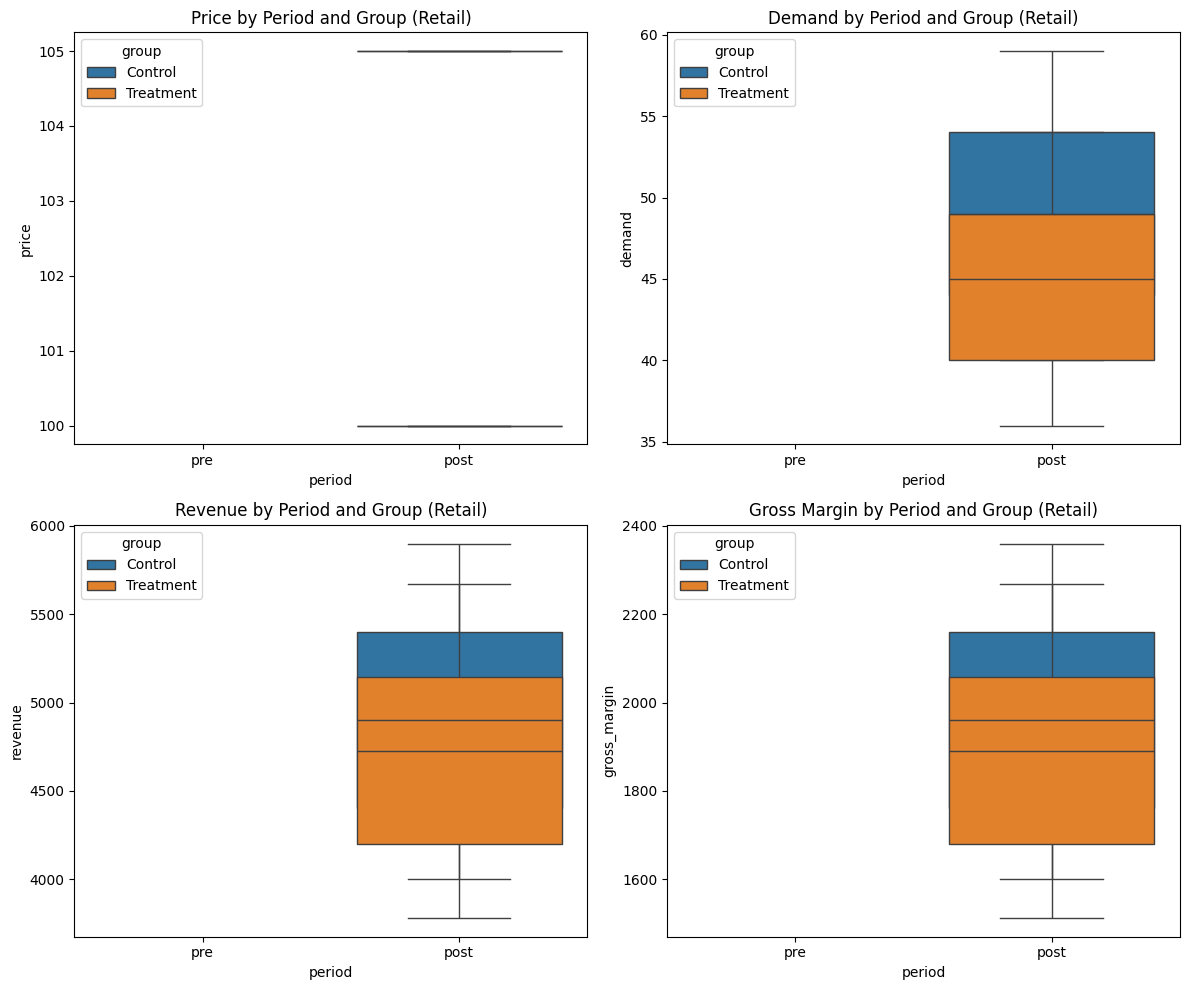

In [ ]:
# Calculate summary statistics by segment and period
summary = df.groupby(['segment', 'period', 'group']).agg({
    'price': 'mean',
    'demand': 'mean',
    'revenue': 'mean',
    'gross_margin': 'mean'
}).round(2)

print("📋 Summary Statistics:")
print(summary)

# Plot pre-post comparison for retail segment
retail_data = df[df['segment'] == 'Retail']
plt.figure(figsize=(12, 10))

# Price comparison
plt.subplot(2, 2, 1)
sns.boxplot(data=retail_data, x='period', y='price', hue='group')
plt.title('Price by Period and Group (Retail)')

# Demand comparison
plt.subplot(2, 2, 2)
sns.boxplot(data=retail_data, x='period', y='demand', hue='group')
plt.title('Demand by Period and Group (Retail)')

# Revenue comparison
plt.subplot(2, 2, 3)
sns.boxplot(data=retail_data, x='period', y='revenue', hue='group')
plt.title('Revenue by Period and Group (Retail)')

# Gross margin comparison
plt.subplot(2, 2, 4)
sns.boxplot(data=retail_data, x='period', y='gross_margin', hue='group')
plt.title('Gross Margin by Period and Group (Retail)')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for statistical testing
pre_data = df[df['period'] == 'pre']
post_data = df[df['period'] == 'post']

# Focus on retail segment for this analysis
retail_post = post_data[post_data['segment'] == 'Retail']
control = retail_post[retail_post['group'] == 'Control']
treatment = retail_post[retail_post['group'] == 'Treatment']

# Perform t-tests for key metrics
metrics = ['demand', 'revenue', 'gross_margin']
results = {}

for metric in metrics:
    t_stat, p_value = stats.ttest_ind(control[metric], treatment[metric])
    results[metric] = {'t_stat': t_stat, 'p_value': p_value}

    print(f"📊 {metric.capitalize()} - T-test results:")
    print(f"   Control mean: {control[metric].mean():.2f}")
    print(f"   Treatment mean: {treatment[metric].mean():.2f}")
    print(f"   T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("   ✅ Statistically significant difference")
    else:
        print("   ❌ No statistically significant difference")
    print()

📊 Demand - T-test results:
   Control mean: 49.41
   Treatment mean: 44.78
   T-statistic: 26.3799, P-value: 0.0000
   ✅ Statistically significant difference

📊 Revenue - T-test results:
   Control mean: 4940.76
   Treatment mean: 4701.40
   T-statistic: 13.3387, P-value: 0.0000
   ✅ Statistically significant difference

📊 Gross_margin - T-test results:
   Control mean: 1976.30
   Treatment mean: 1880.56
   T-statistic: 13.3387, P-value: 0.0000
   ✅ Statistically significant difference



In [ ]:
# Prepare data for Difference-in-Differences analysis
did_data = df[df['segment'] == 'Retail'].copy()
did_data['post'] = (did_data['period'] == 'post').astype(int)
did_data['treated'] = (did_data['group'] == 'Treatment').astype(int)
did_data['interaction'] = did_data['post'] * did_data['treated']

# Run OLS regression for Difference-in-Differences
model = ols('gross_margin ~ post + treated + interaction', data=did_data).fit()
print(model.summary())

# Extract the DiD coefficient (interaction term)
did_effect = model.params['interaction']
did_pvalue = model.pvalues['interaction']

print(f"\n📈 Difference-in-Differences Results:")
print(f"   DiD Estimate: {did_effect:.2f}")
print(f"   P-value: {did_pvalue:.4f}")

if did_pvalue < 0.05:
    print("   ✅ Statistically significant DiD effect")
    print(f"   💰 Estimated impact on gross margin: ${did_effect:.2f} per customer")
else:
    print("   ❌ No statistically significant DiD effect")

                            OLS Regression Results                            
Dep. Variable:           gross_margin   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     72.03
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           5.83e-46
Time:                        13:47:35   Log-Likelihood:                -54825.
No. Observations:                8000   AIC:                         1.097e+05
Df Residuals:                    7996   BIC:                         1.097e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1977.5900      3.623    545.792      

📊 Estimated Price Elasticity: -1.81


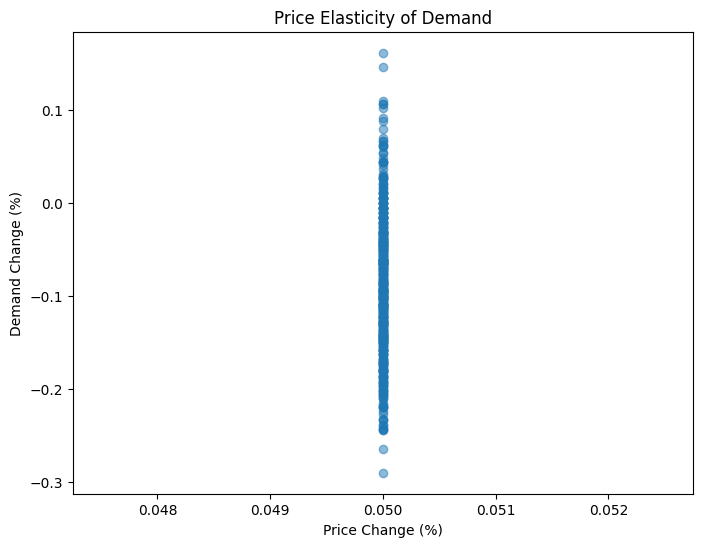

In [ ]:
# Calculate price elasticity for retail segment
retail_data = df[df['segment'] == 'Retail']
price_changes = []
demand_changes = []

# Calculate changes for each customer
for customer_id in retail_data['customer_id'].unique():
    customer_data = retail_data[retail_data['customer_id'] == customer_id]
    pre_data = customer_data[customer_data['period'] == 'pre']
    post_data = customer_data[customer_data['period'] == 'post']

    if len(pre_data) > 0 and len(post_data) > 0:
        pre_price = pre_data['price'].mean()
        post_price = post_data['price'].mean()
        pre_demand = pre_data['demand'].mean()
        post_demand = post_data['demand'].mean()

        price_pct_change = (post_price - pre_price) / pre_price
        demand_pct_change = (post_demand - pre_demand) / pre_demand

        # Only include treatment group customers who actually had a price change
        if price_pct_change > 0:
            price_changes.append(price_pct_change)
            demand_changes.append(demand_pct_change)

# Calculate elasticity
if len(price_changes) > 0:
    elasticity = np.mean(demand_changes) / np.mean(price_changes)
    print(f"📊 Estimated Price Elasticity: {elasticity:.2f}")

    # Visualize the relationship
    plt.figure(figsize=(8, 6))
    plt.scatter(price_changes, demand_changes, alpha=0.5)
    plt.xlabel('Price Change (%)')
    plt.ylabel('Demand Change (%)')
    plt.title('Price Elasticity of Demand')

    # Add trendline
    z = np.polyfit(price_changes, demand_changes, 1)
    p = np.poly1d(z)
    plt.plot(price_changes, p(price_changes), "r--")

    plt.show()
else:
    print("No price changes detected in the data")

📈 Business Impact Analysis:
   Gross Margin Uplift: -4.84%
   Demand Change: -9.38%
   Additional Gross Margin (4 weeks): $-186,128.01
   Annualized Potential: $-2,419,664.10


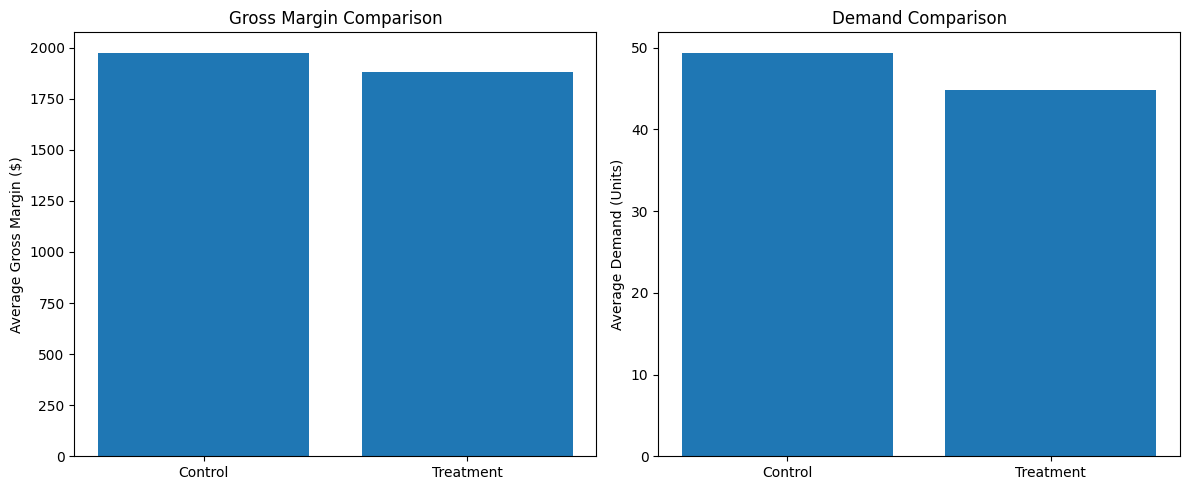

In [ ]:
# Calculate overall business impact
retail_post = df[(df['segment'] == 'Retail') & (df['period'] == 'post')]
control_avg = retail_post[retail_post['group'] == 'Control']['gross_margin'].mean()
treatment_avg = retail_post[retail_post['group'] == 'Treatment']['gross_margin'].mean()

margin_uplift = ((treatment_avg - control_avg) / control_avg) * 100

control_demand = retail_post[retail_post['group'] == 'Control']['demand'].mean()
treatment_demand = retail_post[retail_post['group'] == 'Treatment']['demand'].mean()
demand_change = ((treatment_demand - control_demand) / control_demand) * 100

print("📈 Business Impact Analysis:")
print(f"   Gross Margin Uplift: {margin_uplift:.2f}%")
print(f"   Demand Change: {demand_change:.2f}%")

# Calculate total financial impact
n_treatment_customers = len(retail_post[retail_post['group'] == 'Treatment']['customer_id'].unique())
additional_margin = (treatment_avg - control_avg) * n_treatment_customers * 4  # 4 weeks

print(f"   Additional Gross Margin (4 weeks): ${additional_margin:,.2f}")
print(f"   Annualized Potential: ${additional_margin * 13:,.2f}")  # 13 four-week periods in a year

# Create a summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Margin comparison
ax1.bar(['Control', 'Treatment'], [control_avg, treatment_avg])
ax1.set_ylabel('Average Gross Margin ($)')
ax1.set_title('Gross Margin Comparison')

# Demand comparison
ax2.bar(['Control', 'Treatment'], [control_demand, treatment_demand])
ax2.set_ylabel('Average Demand (Units)')
ax2.set_title('Demand Comparison')

plt.tight_layout()
plt.show()